# Análise da comparação entre as palavras das sentenças do CohQuAD Init en

Realiza a análise da comparação entre as palavras das sentenças dos documentos do conjunto de dados utilizando o arquivo:

- `comparacao_palavra_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 




# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [12]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [16]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [17]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [18]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [19]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 2.1 MB/s 
     |████████████████████████████████| 162 kB 43.8 MB/s 
     |████████████████████████████████| 181 kB 56.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 158 kB 51.6 MB/s 
     |████████████████████████████████| 157 kB 59.2 MB/s 
     |████████████████████████████████| 157 kB 57.9 MB/s 
     |████████████████████████████████| 157 kB 74.9 MB/s 
     |████████████████████████████████| 157 kB 51.4 MB/s 
     |████████████████████████████████| 157 kB 64.9 MB/s 
     |████████████████████████████████| 157 kB 68.2 MB/s 
     |████████████████████████████████| 157 kB 68.2 MB/s 
     |████████████████████████████████| 156 kB 69.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c91c9ab20fd540800b2d55bb7cde6acf85e2ca8060a01340db84c3e42f03

# 2 Parametrização

## Gerais

In [20]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 1 # Somente 1 para o Cohebert Manual

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 1 # Somente 1 para o Cohebert Manual

## Específicos

In [21]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,
    
    pretrained_model_name_or_path = "bert-large-cased",
    #pretrained_model_name_or_path = "bert-base-cased"
    #pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    #modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = True,
    do_lower_case = False,   # default True  
    output_attentions = False,    # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [22]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_INIT_EN"

## Define o caminho para os arquivos de dados

In [23]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [24]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação das palavras



## 3.1 Carregamento dos arquivos de dados originais e perturbados

### 3.1.1 Especifica os nomes dos arquivos de dados



In [25]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [26]:
# Import de bibliotecas
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_INIT_EN


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [27]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [28]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [29]:
# Import de bibliotecas
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [30]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
7,8,['How to pop elements in a stack data structur...,How to pop elements in a stack data structure?
5,6,['How to push and pop elements in a stack data...,How to push and pop elements in a stack data s...
18,19,['In a stack does the pop operation occur at w...,In a stack does the pop operation occur at whi...
8,9,['What is a stack and how to push its element?'],What is a stack and how to push its element?
9,10,['What is a queue and how to enqueue its eleme...,What is a queue and how to enqueue its element?


In [31]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
9,10,"[[['What', 'is', 'a', 'queue', 'and', 'how', '..."
2,3,"[[['How', 'to', 'push', 'elements', 'in', 'a',..."
15,16,"[[['What', 'is', 'a', 'queue', 'and', 'how', '..."
0,1,"[[['How', 'to', 'enqueue', 'elements', 'in', '..."
8,9,"[[['What', 'is', 'a', 'stack', 'and', 'how', '..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [32]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [33]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
1,[How to enqueue elements in a queue?],How to enqueue elements in a queue?
2,[How to dequeue elements in a queue?],How to dequeue elements in a queue?
3,[How to push elements in a stack?],How to push elements in a stack?
4,[How to push and pop elements in a stack?],How to push and pop elements in a stack?
5,[How to push elements in a stack data structure?],How to push elements in a stack data structure?


In [34]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
1,"[[[How, to, enqueue, elements, in, a, queue, ?..."
2,"[[[How, to, dequeue, elements, in, a, queue, ?..."
3,"[[[How, to, push, elements, in, a, stack, ?], ..."
4,"[[[How, to, push, and, pop, elements, in, a, s..."
5,"[[[How, to, push, elements, in, a, stack, data..."


#### Carrega o arquivo dos dados perturbados e POS

In [35]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 20.
INFO:root:TERMINADO PERTURBADOS POS: 20.


AlgUns csv estão com os nomes das colunas errados

In [36]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [37]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
2,3_pert_0,['How to push elements in a queue ?'],How to push elements in a queue ?,"[['How to push elements in a [MASK] ?', 'stack..."
13,14_pert_0,['What is a queue and how to push an element o...,What is a queue and how to push an element on ...,[['What is a [MASK] and how to push an element...
7,8_pert_0,['How to pop elements in a queue data structur...,How to pop elements in a queue data structure ?,[['How to pop elements in a [MASK] data struct...
15,16_pert_0,['What is a stack and how to enqueue and deque...,What is a stack and how to enqueue and dequeue...,[['What is a [MASK] and how to enqueue and deq...
17,18_pert_0,['How are the operations to enqueue and dequeu...,How are the operations to enqueue and dequeue ...,[['How are the operations to enqueue and deque...


In [38]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
2,3_pert_0,"[[['How', 'to', 'push', 'elements', 'in', 'a',..."
8,9_pert_0,"[[['What', 'is', 'a', 'queue', 'and', 'how', '..."
19,20_pert_0,"[[['In', 'a', 'queue', 'does', 'the', 'push', ..."
17,18_pert_0,"[[['How', 'are', 'the', 'operations', 'to', 'e..."
9,10_pert_0,"[[['What', 'is', 'a', 'stack', 'and', 'how', '..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [39]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 20.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 20.


#### Criando dados indexados perturbados

In [40]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
1_pert_0,[How to enqueue elements in a stack ?],How to enqueue elements in a stack ?',"[[How to enqueue elements in a [MASK] ?, queue..."
2_pert_0,[How to dequeue elements in a stack ?],How to dequeue elements in a stack ?',"[[How to dequeue elements in a [MASK] ?, queue..."
3_pert_0,[How to push elements in a queue ?],How to push elements in a queue ?,"[[How to push elements in a [MASK] ?, stack, q..."
4_pert_0,[How to push and pop elements in a queue ?],How to push and pop elements in a queue ?,"[[How to push and pop elements in a [MASK] ?, ..."
5_pert_0,[How to push elements in a queue data structure?],How to push elements in a queue data structure?,[[How to push elements in a [MASK] data struct...


In [41]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
1_pert_0,"[[[How, to, enqueue, elements, in, a, stack, ?..."
2_pert_0,"[[[How, to, dequeue, elements, in, a, stack, ?..."
3_pert_0,"[[[How, to, push, elements, in, a, queue, ?], ..."
4_pert_0,"[[[How, to, push, and, pop, elements, in, a, q..."
5_pert_0,"[[[How, to, push, elements, in, a, queue, data..."


### 5.1.5 Agrupar os dados originais e perturbados

In [42]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [43]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [44]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [45]:
lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
39,20_pert_0,[In a queue does the push operation occur at w...,In a queue does the push operation occur at wh...,0
33,17_pert_0,[How are the operations to push and pop elemen...,How are the operations to push and pop element...,0
9,5_pert_0,[How to push elements in a queue data structure?],How to push elements in a queue data structure?,0
26,14,[What is a stack and how to push an element on...,What is a stack and how to push an element on it?,1
14,8,[How to pop elements in a stack data structure?],How to pop elements in a stack data structure?,1


In [46]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 40.


In [47]:
lista_documentos_agrupados_pos.sample(5)

,id,pos_documento
3,4,"[[[How, to, push, and, pop, elements, in, a, s..."
1,2_pert_0,"[[[How, to, dequeue, elements, in, a, stack, ?..."
16,17,"[[[How, are, the, operations, to, push, and, p..."
3,4_pert_0,"[[[How, to, push, and, pop, elements, in, a, q..."
6,7,"[[[How, to, pop, elements, from, a, stack, ?],..."


#### Criar dados indexados

In [48]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
1,[How to enqueue elements in a queue?],How to enqueue elements in a queue?,1
1_pert_0,[How to enqueue elements in a stack ?],How to enqueue elements in a stack ?',0
2,[How to dequeue elements in a queue?],How to dequeue elements in a queue?,1
2_pert_0,[How to dequeue elements in a stack ?],How to dequeue elements in a stack ?',0
3,[How to push elements in a stack?],How to push elements in a stack?,1


In [49]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

,pos_documento
id,
1,"[[[How, to, enqueue, elements, in, a, queue, ?..."
2,"[[[How, to, dequeue, elements, in, a, queue, ?..."
3,"[[[How, to, push, elements, in, a, stack, ?], ..."
4,"[[[How, to, push, and, pop, elements, in, a, s..."
5,"[[[How, to, push, elements, in, a, stack, data..."


## 3.2 Carregamento do arquivo de dado comparação 

### 3.2.1 Especifica os nomes dos arquivos de dados



In [50]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_COMPACTADO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [51]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/COHQUAD_INIT_EN


In [52]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [53]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

INFO:root:Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [54]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_palavra = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_palavra)))

INFO:root:TERMINADO ORIGINAIS: 2410.


In [55]:
lista_comparacao_palavra.sample(5)

,id,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
1806,17,32,0,1,are,AUX,13,?,PUNCT,0.571289,42.096592,2134.0723,0.571289,42.096592,2134.0723
795,10_pert_0,19,0,0,What,PRON,5,how,SCONJ,0.553335,43.609169,2132.4700,0.553335,43.609169,2132.4700
1637,16,30,0,0,What,PRON,12,?,PUNCT,0.609145,39.960976,1912.7760,0.609145,39.960976,1912.7760
947,11_pert_0,21,0,2,a,DET,3,stack,NOUN,0.585408,41.122536,2037.3083,0.585408,41.122536,2037.3083
1196,13,24,0,3,queue,NOUN,9,element,NOUN,0.694705,32.521770,1627.2146,0.640568,36.526989,1821.3542


### 3.5.5 Criando dados indexados

In [56]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id", "index_sentenca", "index_wi", "index_wj"])
lista_comparacao_palavra_indexado.head()

index_documento   wi  pos_i        wj  \
id index_sentenca index_wi index_wj                                          
1  0              0        1                       0  How  SCONJ        to   
                           2                       0  How  SCONJ   enqueue   
                           3                       0  How  SCONJ  elements   
                           4                       0  How  SCONJ        in   
                           5                       0  How  SCONJ         a   

                                    pos_j  cos_mean   euc_mean   man_mean  \
id index_sentenca index_wi index_wj                                         
1  0              0        1         PART  0.565103  42.296017  2034.9319   
                           2         VERB  0.446486  44.718182  2187.6455   
                           3         NOUN  0.460117  46.351215  2288.4197   
                           4          ADP  0.409433  49.800587  2441.5376   
                           5          DET  0.491628  45.275635  2230.6145   

                                      cos_max    euc_max    man_max  
id index_sentenca index_wi index_wj                                  
1  0              0        1         0.565103  42.296017  2034.9319  
                           2         0.356111  54.109024  2700.0967  
                           3         0.460117  46.351215  2288.4197  
                           4         0.409433  49.800587  2441.5376  
                           5         0.491628  45.275635  2230.6145

## 3.3 Estatísticas

### Estatísticas das medidas dos pares de palavras

In [57]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_palavra[["cos_mean", "euc_mean", "man_mean", "cos_max", "euc_max", "man_max" ]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000
mean,0.536299,41.855296,2062.081779,0.526250,42.931638,2120.808046
std,0.166399,6.106031,275.809964,0.165694,6.107309,279.806210
min,-0.212066,12.597024,633.804700,-0.204871,18.786320,814.356260
25%,0.484549,38.217890,1907.462325,0.470361,39.243323,1957.770150
50%,0.553697,41.762547,2071.974500,0.540683,42.914307,2131.813500
75%,0.623738,45.733429,2252.721875,0.614574,47.015722,2314.187000
max,0.935138,57.766750,2776.515400,0.920012,59.355743,2876.543000


### Estatísticas das maiores discrepâncias por documento

In [58]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

discrepancias  = lista_comparacao_palavra.groupby("id").agg({"cos_mean":[coluna_discrepancia_cos], 
                                                             "euc_mean":[coluna_discrepancia_euc], 
                                                             "man_mean":[coluna_discrepancia_man],
                                                             "cos_max":[coluna_discrepancia_cos], 
                                                             "euc_max":[coluna_discrepancia_euc], 
                                                             "man_max":[coluna_discrepancia_man],
                                                             })

In [59]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
,min,max,max,min,max,max
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.221878,53.637011,2571.780965,0.218108,54.446971,2618.932670
std,0.215984,2.125015,131.102894,0.213233,2.301079,144.490877
min,-0.212066,49.591805,2293.662000,-0.204871,49.591805,2293.662000
25%,0.076103,52.191965,2470.063050,0.076103,52.567169,2485.980875
50%,0.320069,53.915642,2588.777700,0.323211,54.785223,2663.414900
75%,0.371056,55.105376,2671.018500,0.354100,55.917209,2720.082500
max,0.413570,57.766750,2776.515400,0.413570,59.355743,2876.543000


### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [60]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [61]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])

1 a 40
2 ? 40
3 to 36
4 and 28
5 elements 24
6 in 22
7 How 20
8 queue 20
9 stack 20
10 push 17
11 What 16
12 is 16
13 how 16
14 pop 15
15 enqueue 12
16 element 12
17 dequeue 8
18 its 8
19 an 8
20 it 8


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### COS

In [62]:
medida = "cos"

#### MEAN

In [63]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [64]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,148.000000,0.365549,0.263466,-0.193589,0.341029,0.436585,0.552242,0.752652
AUX,248.000000,0.616623,0.122148,-0.137578,0.554337,0.619750,0.678206,0.843420
CCONJ,192.000000,0.515238,0.185648,-0.166353,0.488034,0.540256,0.593405,0.740958
DET,360.000000,0.591775,0.114064,-0.102692,0.527120,0.580924,0.657903,0.835218
NOUN,490.000000,0.562706,0.145358,-0.212066,0.521819,0.570048,0.635949,0.870708
PART,240.000000,0.580186,0.156326,-0.112852,0.551577,0.606018,0.636321,0.847597
PRON,208.000000,0.452416,0.097537,-0.112378,0.399011,0.446717,0.512941,0.653766
SCONJ,288.000000,0.471506,0.143426,-0.162668,0.420510,0.490145,0.555940,0.725399
VERB,236.000000,0.545022,0.171484,-0.173910,0.506913,0.552386,0.620942,0.935138


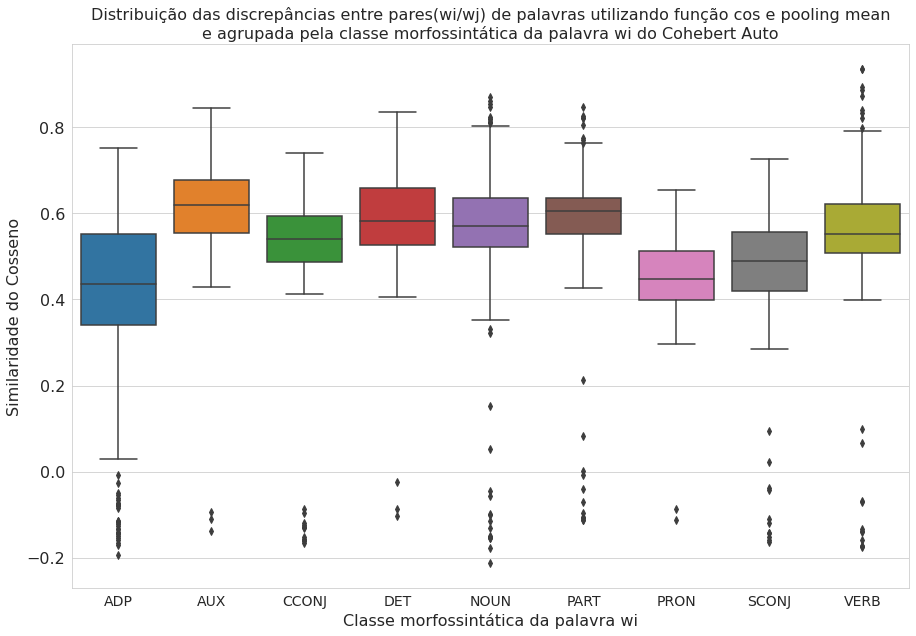

In [65]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [66]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,220.000000,0.400695,0.245388,-0.173910,0.372787,0.501548,0.556992,0.707065
AUX,32.000000,0.531624,0.051717,0.468440,0.498646,0.522222,0.538421,0.656153
CCONJ,132.000000,0.466229,0.240169,-0.212066,0.472154,0.535988,0.584863,0.757417
DET,288.000000,0.565553,0.169350,-0.076659,0.455180,0.556774,0.705386,0.847597
NOUN,682.000000,0.561395,0.153844,-0.193589,0.502422,0.583369,0.648962,0.935138
PART,128.000000,0.618504,0.115183,0.354312,0.543420,0.639027,0.722675,0.792737
PRON,160.000000,0.569742,0.128463,-0.123401,0.521208,0.586092,0.656648,0.782569
PUNCT,412.000000,0.520493,0.125214,-0.164402,0.484734,0.536482,0.574192,0.738990
SCONJ,80.000000,0.573034,0.045354,0.506886,0.534033,0.557982,0.609621,0.673775


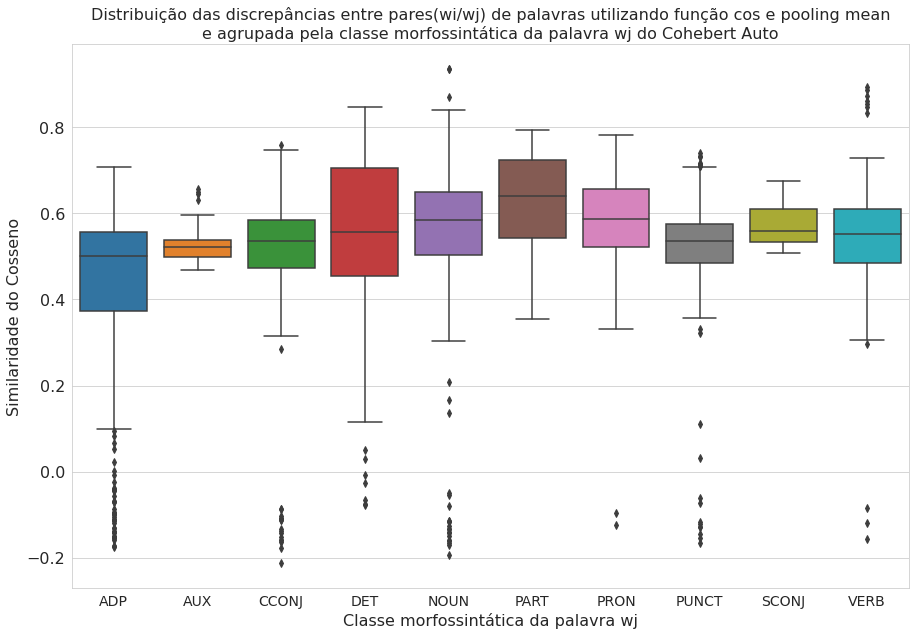

In [67]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

#### MAX

In [68]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [69]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,148.000000,0.362725,0.262868,-0.185512,0.252061,0.444108,0.552242,0.752652
AUX,248.000000,0.608623,0.128434,-0.137578,0.535989,0.619750,0.678206,0.843420
CCONJ,192.000000,0.508932,0.186216,-0.166353,0.475987,0.533932,0.593405,0.740958
DET,360.000000,0.584974,0.117611,-0.102692,0.522269,0.573550,0.655109,0.835218
NOUN,490.000000,0.546198,0.141296,-0.204871,0.505216,0.547874,0.617211,0.834583
PART,240.000000,0.572113,0.158868,-0.112852,0.542341,0.599964,0.635652,0.847597
PRON,208.000000,0.450117,0.098717,-0.112378,0.395072,0.443704,0.512941,0.653766
SCONJ,288.000000,0.468134,0.143393,-0.162668,0.417713,0.480993,0.549534,0.725399
VERB,236.000000,0.516708,0.169660,-0.173910,0.473467,0.523678,0.586357,0.920012


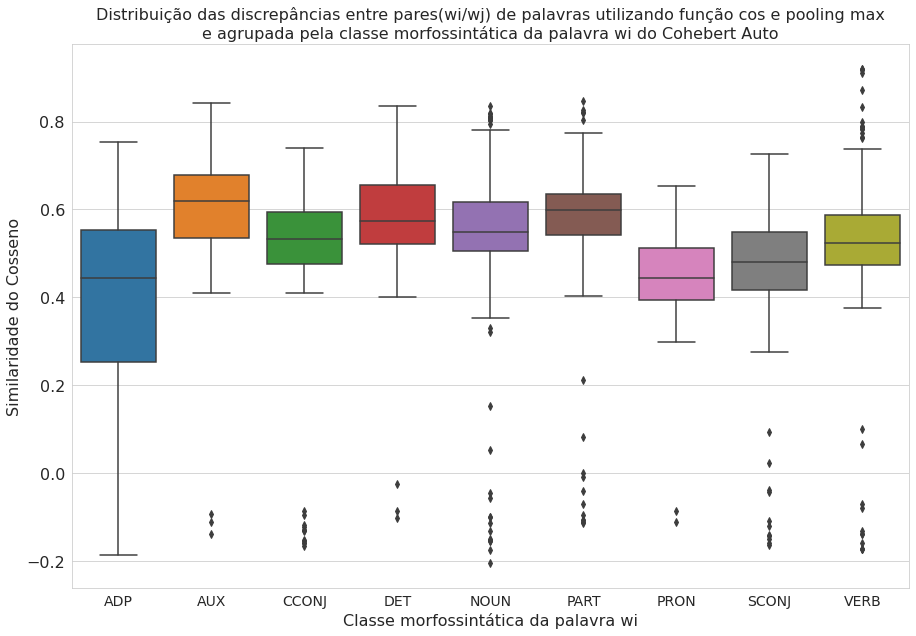

In [70]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [71]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,220.000000,0.392968,0.241058,-0.173910,0.372787,0.490818,0.543889,0.707065
AUX,32.000000,0.528558,0.049709,0.468440,0.498646,0.522222,0.533260,0.656153
CCONJ,132.000000,0.460433,0.238417,-0.204871,0.470291,0.525068,0.584440,0.757417
DET,288.000000,0.559012,0.170906,-0.076659,0.447261,0.545333,0.705386,0.847597
NOUN,682.000000,0.550016,0.150966,-0.185512,0.494302,0.568805,0.632907,0.918695
PART,128.000000,0.615470,0.116167,0.354312,0.540096,0.627239,0.722675,0.792737
PRON,160.000000,0.561393,0.129889,-0.123401,0.505275,0.569871,0.655994,0.782569
PUNCT,412.000000,0.516174,0.126107,-0.164402,0.476395,0.525816,0.574192,0.738990
SCONJ,80.000000,0.569165,0.047117,0.506886,0.530648,0.547073,0.609621,0.673775


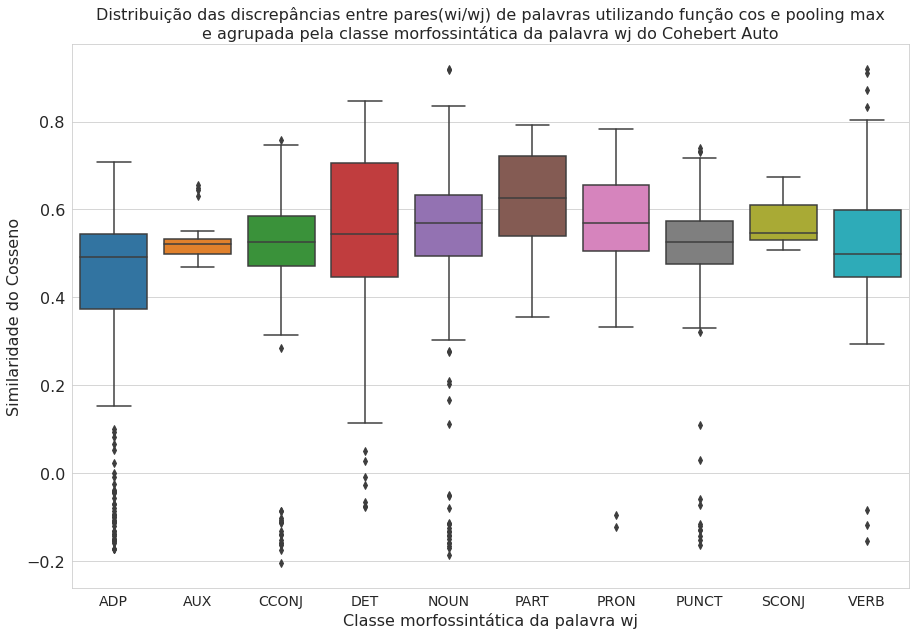

In [72]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

### EUC

In [73]:
medida = "euc"

#### MEAN

In [74]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [75]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,148.000000,46.965907,5.815396,32.162025,43.128689,47.858761,51.843032,55.431015
AUX,248.000000,38.949776,5.218359,25.779480,36.455090,39.311359,41.984856,55.741776
CCONJ,192.000000,42.678839,5.274139,31.924847,39.501480,42.530409,45.823503,55.843838
DET,360.000000,40.088189,5.302612,25.733446,36.675891,41.032829,43.796235,55.237572
NOUN,490.000000,40.191150,5.567960,20.391474,37.013472,40.461250,43.203156,57.766750
PART,240.000000,39.670451,5.192841,24.388636,37.543626,39.135071,41.944272,54.484501
PRON,208.000000,47.371733,3.993479,36.471188,45.064886,47.208427,49.891190,56.352131
SCONJ,288.000000,45.502924,4.919006,33.131622,42.199096,45.232513,48.632510,56.459183
VERB,236.000000,40.092990,6.604435,12.597024,37.548495,40.403038,43.826451,56.525589


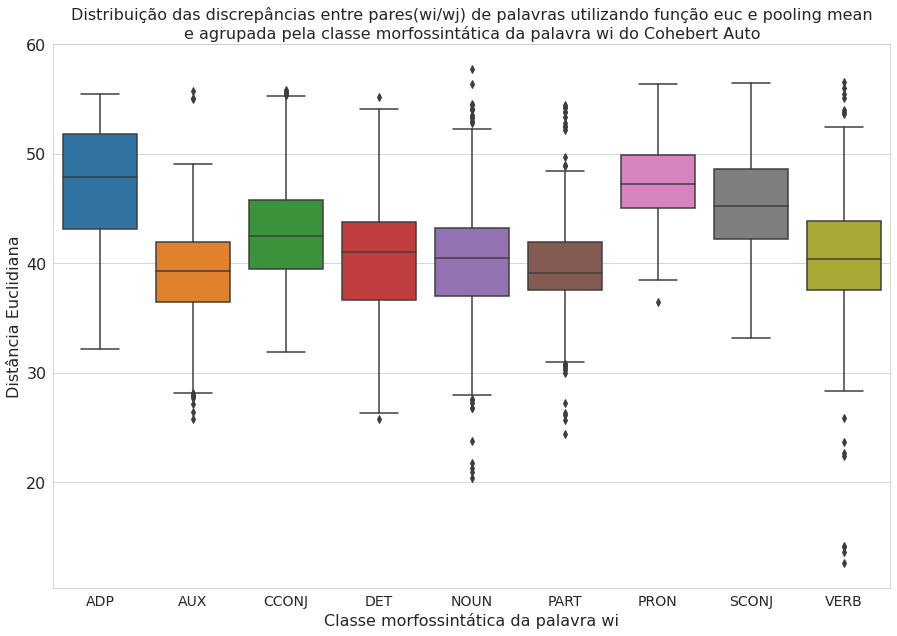

In [76]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [77]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,220.000000,46.508970,5.448687,34.406288,42.133758,46.019939,51.399155,57.766750
AUX,32.000000,44.524954,3.095105,37.807690,43.465223,45.328112,46.796280,47.995834
CCONJ,132.000000,44.330677,6.118717,31.035723,40.344089,43.557884,47.144868,56.352131
DET,288.000000,40.951600,7.754775,24.388636,34.963627,41.759668,47.605997,53.778603
NOUN,682.000000,40.330034,6.125883,14.059526,36.405252,40.246849,44.203796,55.412167
PART,128.000000,39.166933,6.189416,29.494328,34.011159,37.818510,43.367434,53.556816
PRON,160.000000,41.786213,5.516364,31.091198,37.821025,41.543671,44.576769,55.390190
PUNCT,412.000000,42.786043,4.109204,31.924847,40.129554,42.474522,45.128231,55.431015
SCONJ,80.000000,41.739579,2.446500,36.515705,39.496548,41.738819,44.138998,45.666603


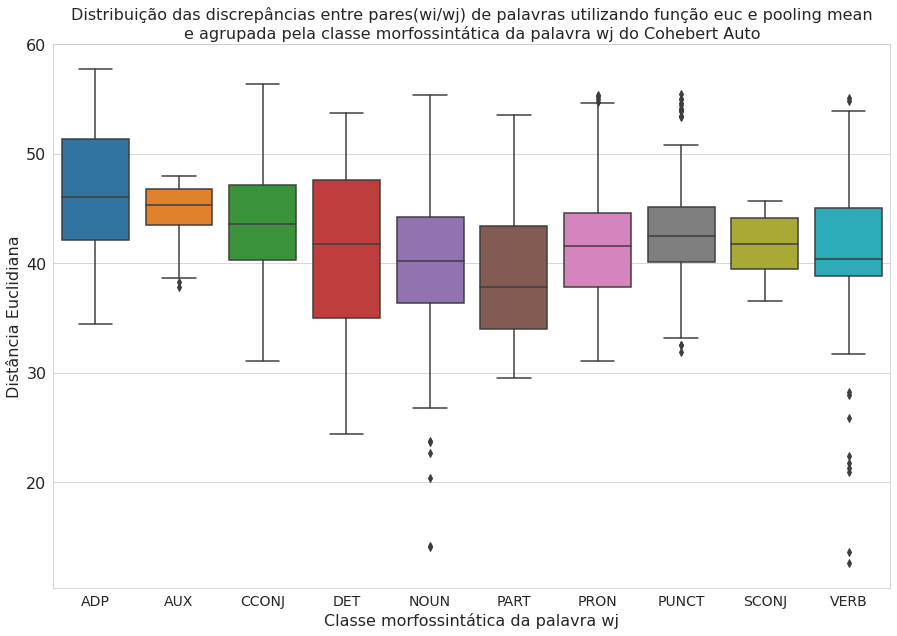

In [78]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAX

In [79]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [80]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,148.000000,47.373550,5.645277,32.162025,43.258073,48.051382,52.003423,55.431015
AUX,248.000000,39.676407,5.853292,25.779480,36.455090,39.692144,43.495236,55.741776
CCONJ,192.000000,43.424653,5.480212,31.924847,40.512461,43.148922,46.954254,55.843838
DET,360.000000,40.746148,5.642104,25.733446,36.927058,41.513794,44.529366,55.237572
NOUN,490.000000,41.720301,5.259944,26.678699,38.816766,42.160988,44.536298,57.766750
PART,240.000000,40.523028,5.715470,24.388636,37.762556,39.781149,44.128855,54.484501
PRON,208.000000,47.844060,4.273312,36.471188,45.064886,48.002329,50.617373,56.352131
SCONJ,288.000000,46.115933,5.051003,33.131622,42.678840,45.938877,49.255083,58.258366
VERB,236.000000,43.248467,6.429512,18.786320,40.534028,43.659021,47.705091,59.355743


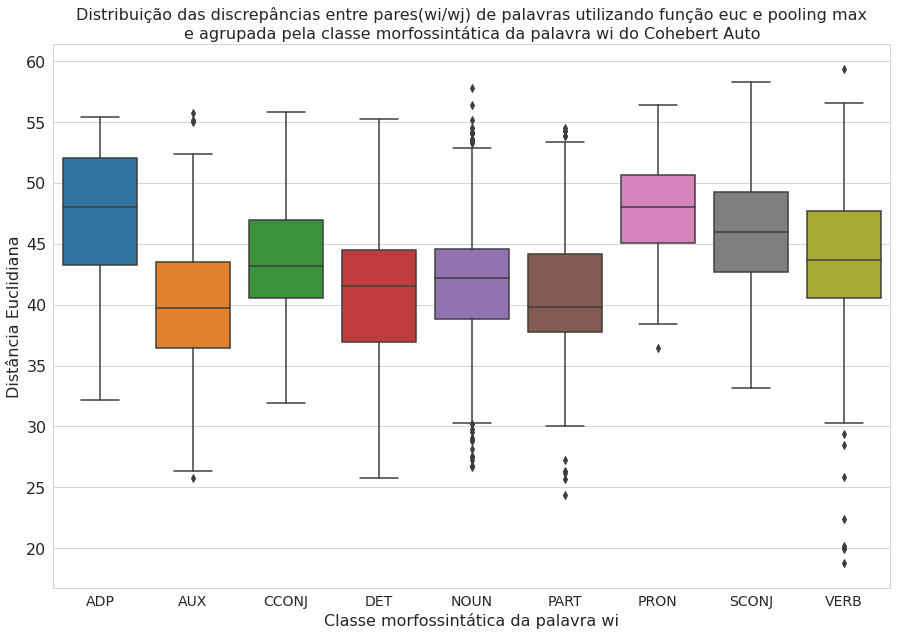

In [81]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [82]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,220.000000,47.210118,5.079717,34.406288,43.134177,46.878607,51.635981,59.355743
AUX,32.000000,44.754641,2.832418,37.807690,43.684262,45.328112,46.796280,47.995834
CCONJ,132.000000,44.853787,6.005980,31.035723,41.471581,43.983170,47.282927,56.352131
DET,288.000000,41.518763,7.920875,24.388636,34.963627,43.167360,48.337305,53.778603
NOUN,682.000000,41.605716,5.937796,19.918892,37.563658,41.407545,45.651625,58.258366
PART,128.000000,39.383167,6.213130,29.494328,34.011159,38.559425,43.462639,53.556816
PRON,160.000000,42.531503,5.637102,31.091198,38.345697,42.073608,45.808551,55.390190
PUNCT,412.000000,43.366861,4.289656,31.924847,40.860155,43.110519,45.904584,55.431015
SCONJ,80.000000,42.037527,2.390823,36.515705,40.024787,42.798199,44.147624,45.666603


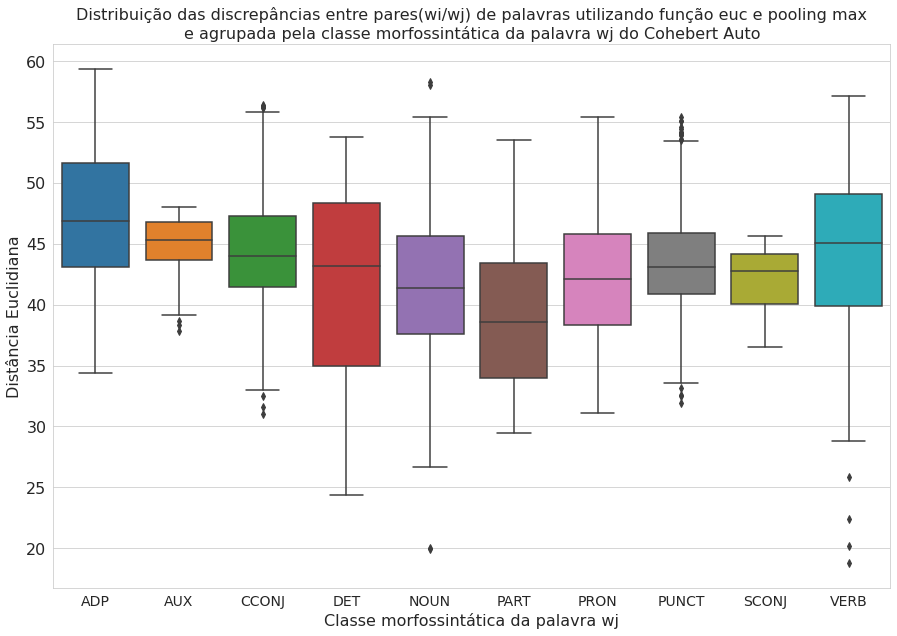

In [83]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

### MAN

In [84]:
medida = "man"

#### MEAN

In [85]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [86]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,148.000000,2175.908784,251.308247,1378.438700,1958.664600,2186.118150,2373.781625,2606.252000
AUX,248.000000,1962.193401,245.288771,1305.174400,1842.607100,1990.896350,2102.970750,2491.650000
CCONJ,192.000000,2104.465403,223.756131,1601.673000,1943.730675,2117.280800,2269.047150,2518.904800
DET,360.000000,2014.818065,265.203767,1300.621100,1839.669775,2057.682000,2209.246925,2521.774000
NOUN,490.000000,1986.731993,268.744499,1028.187400,1839.171000,2024.410750,2145.049575,2766.112300
PART,240.000000,1972.564362,218.021456,1234.391100,1885.063950,1968.297750,2086.740150,2474.542500
PRON,208.000000,2320.484947,201.264617,1824.804300,2203.915825,2308.503650,2456.407200,2776.515400
SCONJ,288.000000,2220.596904,207.790298,1688.440900,2071.457975,2208.823000,2371.788225,2736.204600
VERB,236.000000,1959.575687,312.791519,633.804700,1802.315975,2008.367500,2159.228850,2548.359400


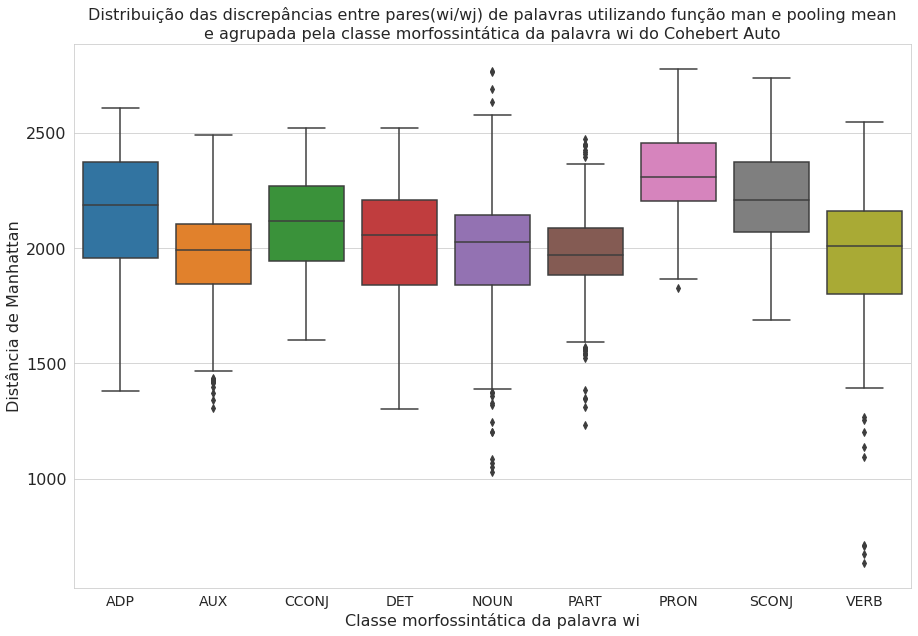

In [87]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [88]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,220.000000,2204.268091,225.653640,1734.921100,2044.490125,2174.931350,2377.020475,2776.515400
AUX,32.000000,2168.286134,121.341179,1914.453400,2128.575200,2166.584450,2271.582150,2329.503200
CCONJ,132.000000,2125.516735,218.484180,1602.430800,2006.641125,2120.309100,2275.467925,2736.204600
DET,288.000000,2037.072066,364.000253,1234.391100,1777.832000,2072.778050,2307.404675,2687.649400
NOUN,682.000000,1979.594304,285.385611,708.995900,1791.276250,1995.411000,2163.485950,2721.625000
PART,128.000000,1958.093767,283.122331,1505.825400,1711.560525,1916.620750,2110.522350,2629.060300
PRON,160.000000,2096.764746,256.845526,1575.466100,1924.677500,2078.565700,2255.091850,2736.837000
PUNCT,412.000000,2134.626889,191.685224,1601.673000,2002.837800,2121.890350,2267.877650,2766.112300
SCONJ,80.000000,2103.621654,103.414181,1878.721600,2030.069575,2102.365250,2179.140550,2315.464400


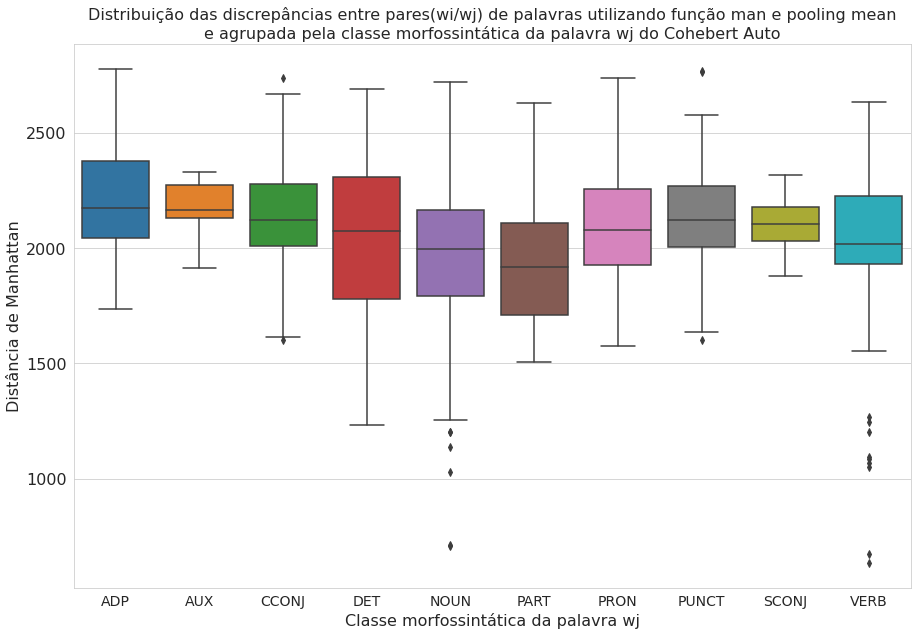

In [89]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

#### MAX

In [90]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [91]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,148.000000,2196.822561,246.385576,1566.964600,2041.142375,2186.118150,2381.112950,2715.649400
AUX,248.000000,1999.750568,278.550545,1305.174400,1842.607100,2012.890400,2173.041225,2629.776900
CCONJ,192.000000,2145.682352,241.230100,1601.673000,1990.554775,2155.753400,2330.472750,2642.283200
DET,360.000000,2051.722622,283.082357,1300.621100,1862.203450,2096.634700,2243.256000,2650.987500
NOUN,490.000000,2068.143630,256.948233,1311.439500,1911.217700,2099.947150,2219.505450,2766.112300
PART,240.000000,2019.827257,252.238577,1234.391100,1907.148050,1995.572500,2168.186300,2655.165500
PRON,208.000000,2346.827106,214.452900,1824.804300,2209.053375,2352.922400,2486.563850,2776.515400
SCONJ,288.000000,2255.495966,218.724170,1688.440900,2099.493725,2255.197850,2403.056750,2876.543000
VERB,236.000000,2133.968472,318.688059,814.356260,2007.072350,2165.875500,2333.250325,2730.910000


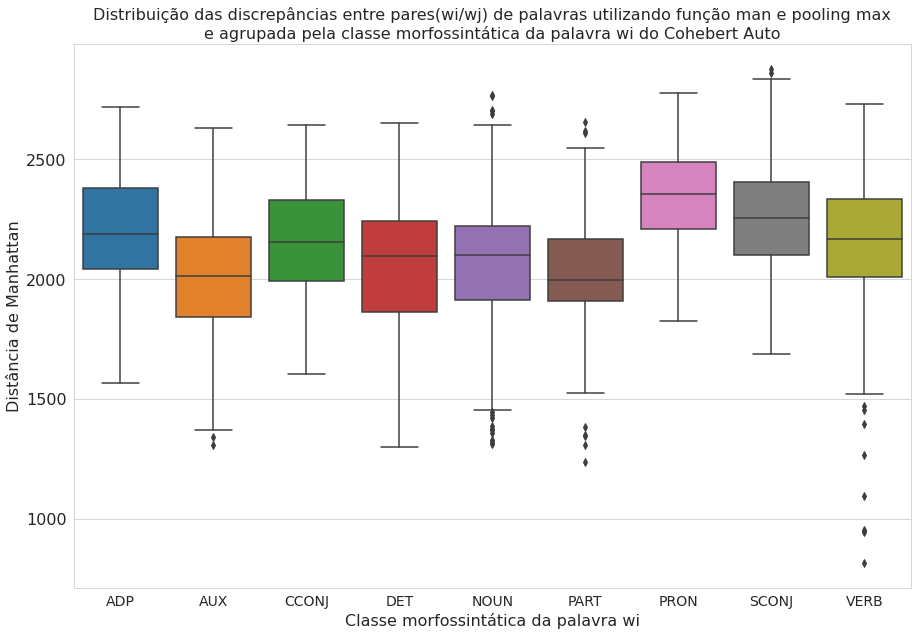

In [92]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [93]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,220.000000,2240.810048,215.909459,1749.151000,2094.823775,2232.340700,2418.471125,2776.515400
AUX,32.000000,2178.595894,112.824784,1914.453400,2132.614800,2173.201550,2271.582150,2329.503200
CCONJ,132.000000,2153.049964,217.903023,1602.430800,2047.891400,2153.125500,2280.785875,2736.204600
DET,288.000000,2066.868174,375.921659,1234.391100,1777.832000,2118.382100,2360.436200,2688.480200
NOUN,682.000000,2052.406116,277.291361,942.954000,1858.042275,2065.248550,2238.413100,2876.543000
PART,128.000000,1968.519867,284.857060,1505.825400,1711.560525,1959.045450,2123.359525,2629.060300
PRON,160.000000,2136.480942,265.647445,1575.466100,1939.869025,2122.834250,2296.724425,2736.837000
PUNCT,412.000000,2166.192727,203.260476,1601.673000,2031.810875,2150.089350,2303.126375,2766.112300
SCONJ,80.000000,2116.456099,102.087866,1878.721600,2043.273350,2132.104400,2182.515900,2315.464400


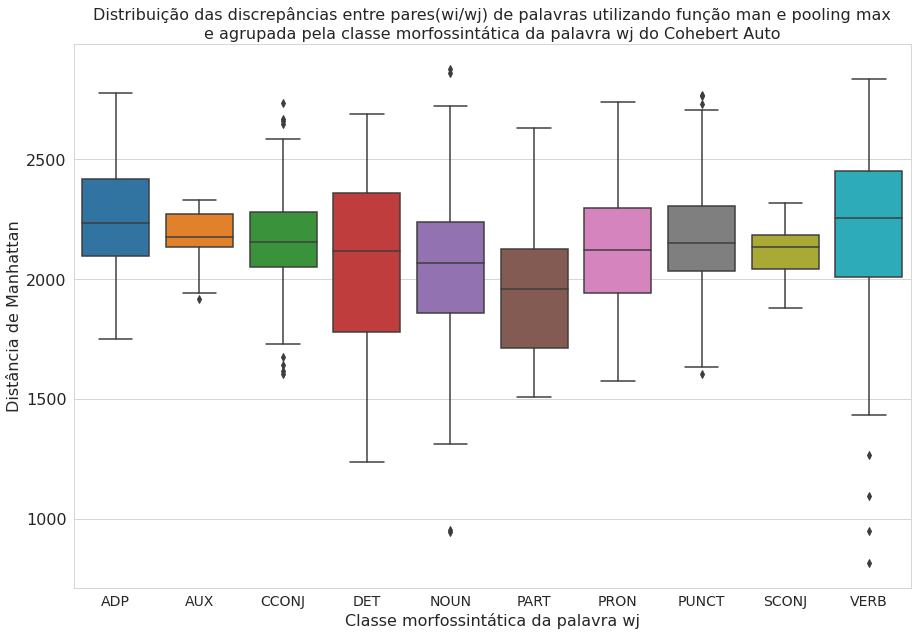

In [94]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias de determinados pares de palavras

### Geral

Conta pares de classes de palavras

In [95]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_palavra.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_palavra))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao["pos_i"]+"/"+linha_comparacao["pos_j"]] += 1

Documentos:   0%|          | 0/2410 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [96]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

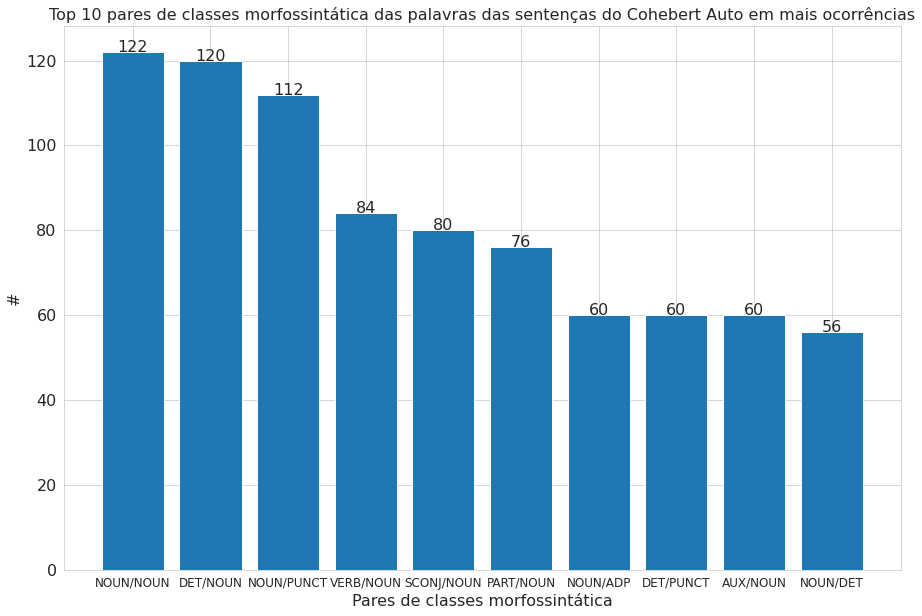

In [97]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do Cohebert Auto em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### VERB-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [98]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 8


Estatísticas das medidas dos pares de palavras

In [99]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.690141,31.205093,1554.145325,0.668537,35.226603,1738.517377
std,0.197570,14.374560,722.483910,0.231956,14.526646,770.321253
min,0.447872,12.597024,633.804700,0.439803,18.786320,814.356260
25%,0.534939,20.210164,989.539475,0.446572,21.852520,1058.202190
50%,0.692983,33.019926,1641.842300,0.658051,36.169495,1792.351750
75%,0.875319,41.856991,2103.746300,0.881264,48.581013,2429.396950
max,0.894158,48.155682,2396.698200,0.920012,50.067791,2541.926300


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [100]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/8 [00:00<?, ? documento/s]

In [101]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [102]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque palavra  #wi
      1    push    4
      2 enqueue    4


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [103]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/8 [00:00<?, ? documento/s]

In [104]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [105]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1 implemented    4
      2         pop    2
      3     dequeue    2


#### COS

In [106]:
medida = "cos_mean"

Documentos outliers

In [107]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.3403797894716263
Limite superior             : 1.3858888521790504
Limite inferior             : 0.02436969429254532


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [108]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 8 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [109]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 8 ( 0.0 )


In [110]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 8 ( 0.0 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [111]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [112]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### EUC

In [113]:
medida = "euc_mean"

Documentos outliers

In [114]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 21.64682722091675
Limite superior             : 74.3272316455841
Limite inferior             : -12.260077238082896


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [115]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 8 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [116]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 8 ( 0.0 )


In [117]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 8 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB


In [118]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB


In [119]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### MAN

In [120]:
medida = "man_mean"

Documentos outliers

In [121]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 1114.2068249999998
Limite superior             : 3775.0565374999996
Limite inferior             : -681.7707624999996


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [122]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 8 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [123]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 8 ( 0.0 )


In [124]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 8 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB

In [125]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_inferior) entre palavras da classe VERB

In [126]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

### NOUN-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [127]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 122


Estatísticas das medidas dos pares de palavras

In [128]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,0.664448,35.250970,1746.859771,0.643791,37.212228,1855.534753
std,0.088503,5.060610,265.467081,0.090048,5.476518,291.371335
min,0.429650,20.391474,1028.187400,0.429650,26.678699,1311.439500
25%,0.624999,32.269728,1585.357325,0.584200,33.886292,1665.725750
50%,0.684151,34.337749,1695.912250,0.655223,36.428802,1813.250400
75%,0.715153,37.409769,1854.965325,0.700622,40.641292,2041.478900
max,0.870708,49.402847,2531.152000,0.834583,49.402847,2531.152000


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [129]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/122 [00:00<?, ? documento/s]

In [130]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [131]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque    palavra  #wi
      1   elements   32
      2      stack   20
      3      queue   20
      4        pop   18
      5 operations   12
      6       data    6
      7    dequeue    4
      8  operation    4
      9    enqueue    4
     10       push    2


Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [132]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/122 [00:00<?, ? documento/s]

In [133]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [134]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque   palavra  #wj
      1 structure   20
      2     queue   16
      3     stack   16
      4  elements   16
      5      data   14
      6   element   12
      7       end   12
      8 operation    8
      9       pop    3
     10   dequeue    2
     11   enqueue    2
     12      push    1


#### COS

In [135]:
medida = "cos_mean"

Documentos outliers

In [136]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.09015487134456635
Limite superior             : 0.8503857031464577
Limite inferior             : 0.4897662177681923


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [137]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 8 de 122 ( 0.06557377049180328 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [138]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 122 ( 0.00819672131147541 )


In [139]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  9 de 122 ( 0.07377049180327869 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [140]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.8707084655761719 queue enqueue
         In a queue does the enqueue operation occur at which end? 1


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [141]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.4296500980854034 pop structure
         How to push and pop elements in a queue data structure ? 0

 2 0.4365687370300293 pop structure
         How to push and pop elements in a stack data structure? 1

 3 0.4531181752681732 pop data
         How to push and pop elements in a stack data structure? 1

 4 0.456855833530426 pop queue
         How to push and pop elements in a queue ? 0

 5 0.4636380672454834 pop data
         How to push and pop elements in a queue data structure ? 0


#### EUC

In [142]:
medida = "euc_mean"

Documentos outliers

In [143]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.140041351318359
Limite superior             : 45.11983108520508
Limite inferior             : 24.55966567993164


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [144]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 8


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [145]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 122 ( 0.01639344262295082 )


In [146]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  10 de 122 ( 0.08196721311475409 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN

In [147]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 49.40284729003906 pop structure
         How to push and pop elements in a queue data structure ? 0

 2 49.330074310302734 pop structure
         How to push and pop elements in a stack data structure? 1

 3 48.60812377929688 pop data
         How to push and pop elements in a stack data structure? 1

 4 47.82490158081055 pop data
         How to push and pop elements in a queue data structure ? 0

 5 46.51352310180664 pop stack
         How to push and pop elements in a stack data structure? 1


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN


In [148]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 20.3914737701416 queue enqueue
         In a queue does the enqueue operation occur at which end? 1

 2 23.79183959960937 dequeue queue
         How are the operations to enqueue and dequeue elements in a queue implemented? 1


#### MAN

In [149]:
medida = "man_mean"

Documentos outliers

In [150]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 269.60799999999995
Limite superior             : 2259.377325
Limite inferior             : 1180.9453250000001


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [151]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 8


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [152]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 122 ( 0.00819672131147541 )


In [153]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  9 de 122 ( 0.07377049180327869 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN

In [154]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]] 
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"] 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 2531.152 pop structure
         How to push and pop elements in a stack data structure? 1

 2 2502.8813 pop structure
         How to push and pop elements in a queue data structure ? 0

 3 2466.63 pop data
         How to push and pop elements in a stack data structure? 1

 4 2425.4604 pop data
         How to push and pop elements in a queue data structure ? 0

 5 2356.8286 pop stack
         How to push and pop elements in a stack data structure? 1


Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN

In [155]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 1028.1874 queue enqueue
         In a queue does the enqueue operation occur at which end? 1


### NOUN-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [156]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesNV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 52


Estatísticas das medidas dos pares de palavras

In [157]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.627868,37.024401,1831.879502,0.593056,40.428867,2016.949912
std,0.084396,5.649061,298.844600,0.092534,5.240123,270.950401
min,0.418851,20.923059,1051.599200,0.418851,28.831713,1433.723400
25%,0.584414,34.766870,1723.277625,0.518420,37.229193,1862.193025
50%,0.621335,37.405199,1872.851300,0.606790,39.296783,1947.923900
75%,0.669807,39.804110,1991.609250,0.642292,44.066337,2200.299275
max,0.860309,49.215565,2458.567900,0.803714,50.904301,2574.698700


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [158]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/52 [00:00<?, ? documento/s]

In [159]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [160]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque    palavra  #wi
      1      stack   14
      2      queue   14
      3 operations    8
      4   elements    4
      5  operation    4
      6        pop    3
      7    dequeue    2
      8    enqueue    2
      9       push    1


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [161]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/52 [00:00<?, ? documento/s]

In [162]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [163]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1 implemented   16
      2       occur   12
      3        push    8
      4     enqueue    8
      5     dequeue    4
      6         pop    4


#### COS

In [164]:
medida = "cos_mean"

Documentos outliers

In [165]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.08539310097694397
Limite superior             : 0.7978970557451248
Limite inferior             : 0.45632465183734894


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [166]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 52 ( 0.038461538461538464 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [167]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 3 de 52 ( 0.057692307692307696 )


In [168]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5 de 52 ( 0.09615384615384616 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [169]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.8603087067604065 queue dequeue
         What is a queue and how to dequeue an element in it? 1

 2 0.8540165424346924 queue enqueue
         What is a queue and how to enqueue an element in it? 1

 3 0.8471419215202332 queue enqueue
         What is a queue and how to enqueue its element? 1


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [170]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 0.4188514351844787 pop implemented
         How are the operations to push and pop elements in a queue implemented ? 0

 2 0.4281764924526214 pop implemented
         How are the operations to push and pop elements in a stack implemented? 1


#### EUC

In [171]:
medida = "euc_mean"

Documentos outliers

In [172]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.0372400283813406
Limite superior             : 47.359969615936265
Limite inferior             : 27.2110095024109


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [173]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 52 ( 0.038461538461538464 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [174]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 52 ( 0.057692307692307696 )


In [175]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5 de 52 ( 0.09615384615384616 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [176]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 49.2155647277832 pop implemented
         How are the operations to push and pop elements in a stack implemented? 1

 2 49.21431350708008 pop implemented
         How are the operations to push and pop elements in a queue implemented ? 0


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [177]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 20.923059463500977 queue dequeue
         What is a queue and how to dequeue an element in it? 1

 2 21.310379028320312 queue enqueue
         What is a queue and how to enqueue an element in it? 1

 3 21.712278366088867 queue enqueue
         What is a queue and how to enqueue its element? 1


#### MAN

In [178]:
medida = "man_mean"

Documentos outliers

In [179]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 268.33162500000003
Limite superior             : 2394.1066875
Limite inferior             : 1320.7801875


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [180]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 52 ( 0.038461538461538464 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)


In [181]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5 de 52 ( 0.09615384615384616 )


In [182]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7 de 52 ( 0.1346153846153846 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [183]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 2458.5679 pop implemented
         How are the operations to push and pop elements in a queue implemented ? 0

 2 2458.2087 pop implemented
         How are the operations to push and pop elements in a stack implemented? 1


Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [184]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 1051.5992 queue dequeue
         What is a queue and how to dequeue an element in it? 1

 2 1069.5032 queue enqueue
         What is a queue and how to enqueue an element in it? 1

 3 1085.719 queue enqueue
         What is a queue and how to enqueue its element? 1

 4 1200.0857 queue enqueue
         What is a queue and how to enqueue and dequeue its elements? 1

 5 1244.6854 queue dequeue
         What is a queue and how to enqueue and dequeue its elements? 1


### VERB-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [185]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesVN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 84


Estatísticas das medidas dos pares de palavras

In [186]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean", "euc_mean","man_mean"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean
count,84.000000,84.000000,84.000000
mean,0.636902,36.035473,1762.970557
std,0.093766,5.854805,301.289888
min,0.462669,14.059526,708.995900
25%,0.568934,33.178713,1604.068675
50%,0.630598,35.961451,1747.976400
75%,0.675472,40.442753,2012.435175
max,0.935138,46.079121,2304.335000


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [187]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/84 [00:00<?, ? documento/s]

In [188]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [189]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque palavra  #wi
      1    push   40
      2 enqueue   16
      3     pop   16
      4 dequeue    8
      5   occur    4


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [190]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/84 [00:00<?, ? documento/s]

In [191]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [192]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque   palavra  #wj
      1  elements   28
      2   element   12
      3     queue   10
      4     stack   10
      5       pop    6
      6      data    6
      7 structure    6
      8       end    4
      9   dequeue    2


#### COS

In [193]:
medida = "cos_mean"

Documentos outliers

In [194]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.10653753578662872
Limite superior             : 0.83527822047472
Limite inferior             : 0.4091280773282051


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [195]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 84 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [196]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 3 de 84 ( 0.03571428571428571 )


In [197]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 84 ( 0.03571428571428571 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [198]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 0.9351377487182616 enqueue dequeue
         How are the operations to enqueue and dequeue elements in a queue implemented? 1

 2 0.9338610172271729 enqueue dequeue
         How are the operations to enqueue and dequeue elements in a stack implemented ? 0

 3 0.8404576778411865 enqueue queue
         How are the operations to enqueue and dequeue elements in a queue implemented? 1


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [199]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

#### EUC

In [200]:
medida = "euc_mean"

Documentos outliers

In [201]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 7.264039993286133
Limite superior             : 51.338812828063965
Limite inferior             : 22.282652854919434


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [202]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 84 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [203]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 84 ( 0.023809523809523808 )


In [204]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 84 ( 0.023809523809523808 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [205]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [206]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"]) 
          cont = cont + 1


 1 14.059526443481444 enqueue dequeue
         How are the operations to enqueue and dequeue elements in a queue implemented? 1

 2 14.137659072875977 enqueue dequeue
         How are the operations to enqueue and dequeue elements in a stack implemented ? 0


#### MAN

In [207]:
medida = "man_mean"

Documentos outliers

In [208]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 408.3665000000001
Limite superior             : 2624.984925
Limite inferior             : 991.5189249999999


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [209]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 84 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [210]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 84 ( 0.023809523809523808 )


In [211]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 84 ( 0.023809523809523808 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [212]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [213]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 708.9959 enqueue dequeue
         How are the operations to enqueue and dequeue elements in a queue implemented? 1

 2 711.24976 enqueue dequeue
         How are the operations to enqueue and dequeue elements in a stack implemented ? 0


### Comparando discrepância entre pares de palavras de determinadas classes

#### COS, EUC, MAN

In [214]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna()
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                              \
         cos_mean    euc_mean    man_mean     cos_max     euc_max     man_max   
count 2410.000000 2410.000000 2410.000000 2410.000000 2410.000000 2410.000000   
mean     0.536299   41.855296 2062.081779    0.526250   42.931638 2120.808046   
std      0.166399    6.106031  275.809964    0.165694    6.107309  279.806210   
min     -0.212066   12.597024  633.804700   -0.204871   18.786320  814.356260   
25%      0.484549   38.217890 1907.462325    0.470361   39.243323 1957.770150   
50%      0.553697   41.762547 2071.974500    0.540683   42.914307 2131.813500   
75%      0.623738   45.733429 2252.721875    0.614574   47.015722 2314.187000   
max      0.935138   57.766750 2776.515400    0.920012   59.355743 2876.543000   

      VERB-VERB                                 ...   NOUN-VERB            \
       cos_mean  euc_mean    man_mean  cos_max  ...    man_mean   cos_max   
count  8.000000  8.000000    8.000000 8.000000  ...   52.000000 52.000000   
mean   0.690141 31.205093 1554.145325 0.668537  ... 1831.879502  0.593056   
std    0.197570 14.374560  722.483910 0.231956  ...  298.844600  0.092534   
min    0.447872 12.597024  633.804700 0.439803  ... 1051.599200  0.418851   
25%    0.534939 20.210164  989.539475 0.446572  ... 1723.277625  0.518420   
50%    0.692983 33.019926 1641.842300 0.658051  ... 1872.851300  0.606790   
75%    0.875319 41.856991 2103.746300 0.881264  ... 1991.609250  0.642292   
max    0.894158 48.155682 2396.698200 0.920012  ... 2458.567900  0.803714   

                            VERB-NOUN                                  \
        euc_max     man_max  cos_mean  euc_mean    man_mean   cos_max   
count 52.000000   52.000000 84.000000 84.000000   84.000000 84.000000   
mean  40.428867 2016.949912  0.636902 36.035473 1762.970557  0.612999   
std    5.240123  270.950401  0.093766  5.854805  301.289888  0.091364   
min   28.831713 1433.723400  0.462669 14.059526  708.995900  0.475172   
25%   37.229193 1862.193025  0.568934 33.178713 1604.068675  0.553081   
50%   39.296783 1947.923900  0.630598 35.961451 1747.976400  0.592696   
75%   44.066337 2200.299275  0.675472 40.442753 2012.435175  0.655252   
max   50.904301 2574.698700  0.935138 46.079121 2304.335000  0.918695   

                             
        euc_max     man_max  
count 84.000000   84.000000  
mean  38.909824 1934.227614  
std    5.371387  285.804465  
min   19.918892  942.954000  
25%   35.777806 1750.189075  
50%   40.464214 2017.054650  
75%   42.647722 2128.228800  
max   48.484203 2446.924300  

[8 rows x 30 columns]

#### COS

In [215]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,cos_mean,cos_mean,cos_mean,cos_mean,cos_mean
count,2410.000000,8.000000,122.000000,52.000000,84.000000
mean,0.536299,0.690141,0.664448,0.627868,0.636902
std,0.166399,0.197570,0.088503,0.084396,0.093766
min,-0.212066,0.447872,0.429650,0.418851,0.462669
25%,0.484549,0.534939,0.624999,0.584414,0.568934
50%,0.553697,0.692983,0.684151,0.621335,0.630598
75%,0.623738,0.875319,0.715153,0.669807,0.675472
max,0.935138,0.894158,0.870708,0.860309,0.935138


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


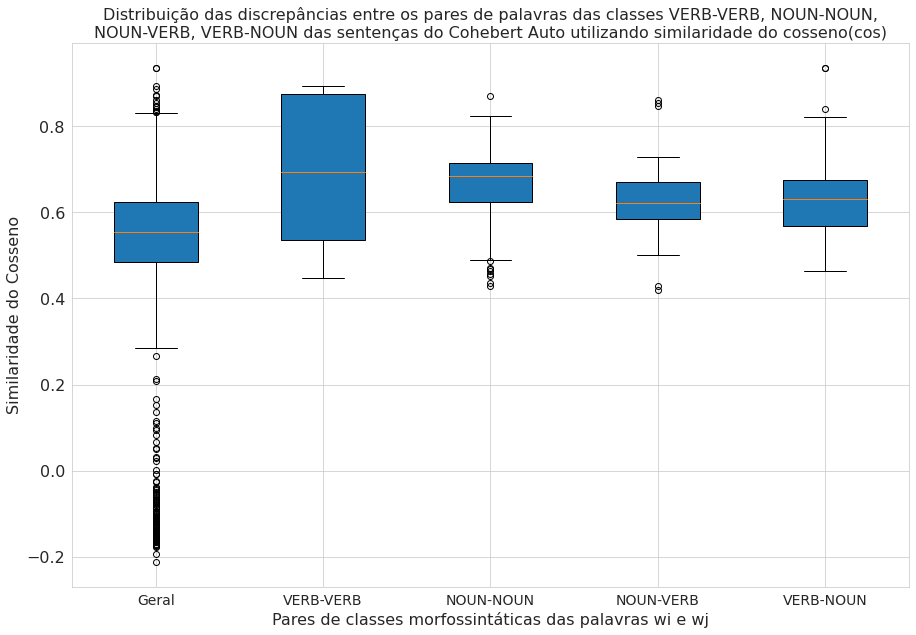

In [216]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_palavra[["cos_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_mean"]].dropna(),
           lista_comparacao_classesNV[["cos_mean"]].dropna(),
           lista_comparacao_classesVN[["cos_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### EUC

In [217]:
df_all = pd.concat([lista_comparacao_palavra[["euc_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_mean"]].dropna(),
                    lista_comparacao_classesNV[["euc_mean"]].dropna(),
                    lista_comparacao_classesVN[["euc_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,euc_mean,euc_mean,euc_mean,euc_mean,euc_mean
count,2410.000000,8.000000,122.000000,52.000000,84.000000
mean,41.855296,31.205093,35.250970,37.024401,36.035473
std,6.106031,14.374560,5.060610,5.649061,5.854805
min,12.597024,12.597024,20.391474,20.923059,14.059526
25%,38.217890,20.210164,32.269728,34.766870,33.178713
50%,41.762547,33.019926,34.337749,37.405199,35.961451
75%,45.733429,41.856991,37.409769,39.804110,40.442753
max,57.766750,48.155682,49.402847,49.215565,46.079121


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


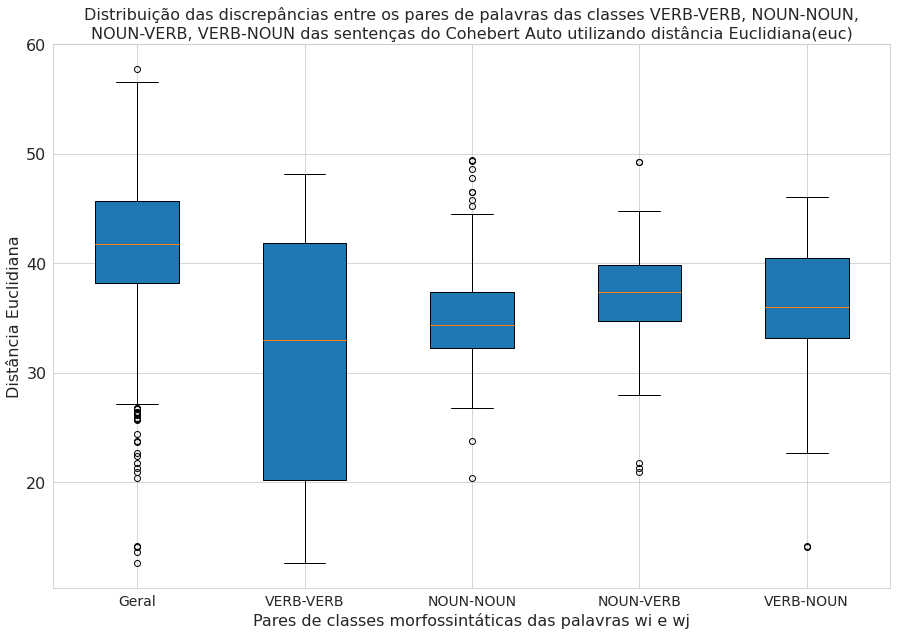

In [218]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_palavra[["euc_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_mean"]].dropna(),
           lista_comparacao_classesNV[["euc_mean"]].dropna(),
           lista_comparacao_classesVN[["euc_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### MAN

In [219]:
df_all = pd.concat([lista_comparacao_palavra[["man_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_mean"]].dropna(),
                    lista_comparacao_classesNV[["man_mean"]].dropna(),
                    lista_comparacao_classesVN[["man_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,man_mean,man_mean,man_mean,man_mean,man_mean
count,2410.000000,8.000000,122.000000,52.000000,84.000000
mean,2062.081779,1554.145325,1746.859771,1831.879502,1762.970557
std,275.809964,722.483910,265.467081,298.844600,301.289888
min,633.804700,633.804700,1028.187400,1051.599200,708.995900
25%,1907.462325,989.539475,1585.357325,1723.277625,1604.068675
50%,2071.974500,1641.842300,1695.912250,1872.851300,1747.976400
75%,2252.721875,2103.746300,1854.965325,1991.609250,2012.435175
max,2776.515400,2396.698200,2531.152000,2458.567900,2304.335000


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


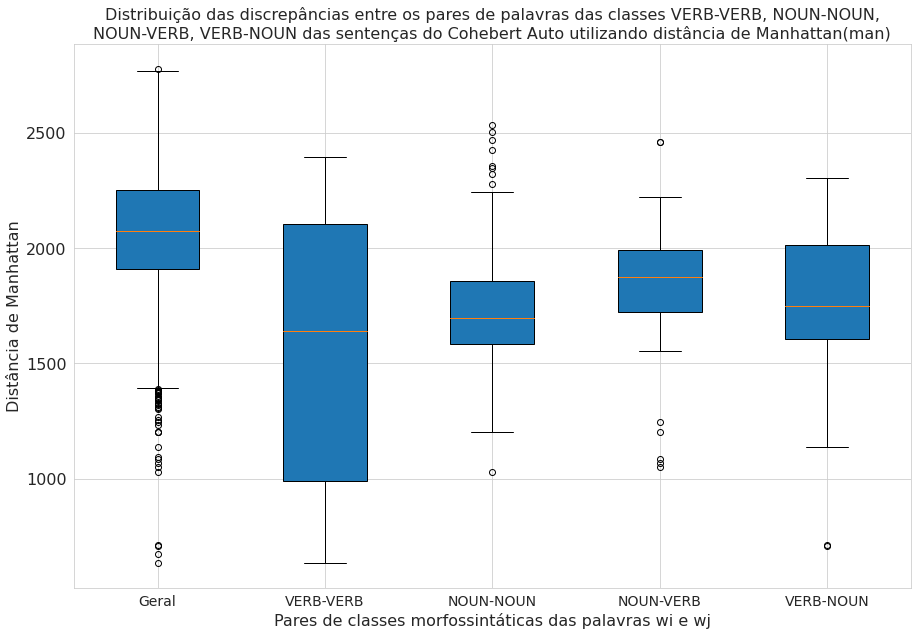

In [220]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_palavra[["man_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_mean"]].dropna(),
           lista_comparacao_classesNV[["man_mean"]].dropna(),
           lista_comparacao_classesVN[["man_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

## 3.6 Ocorrências de pares de palavras

### Indexa os dados das comparações pelo id do documento

In [221]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id"])
lista_comparacao_palavra_indexado.head()

,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
id,,,,,,,,,,,,,,
1,0,0,0,How,SCONJ,1,to,PART,0.565103,42.296017,2034.931900,0.565103,42.296017,2034.931900
1,0,0,0,How,SCONJ,2,enqueue,VERB,0.446486,44.718182,2187.645500,0.356111,54.109024,2700.096700
1,0,0,0,How,SCONJ,3,elements,NOUN,0.460117,46.351215,2288.419700,0.460117,46.351215,2288.419700
1,0,0,0,How,SCONJ,4,in,ADP,0.409433,49.800587,2441.537600,0.409433,49.800587,2441.537600
1,0,0,0,How,SCONJ,5,a,DET,0.491628,45.275635,2230.614500,0.491628,45.275635,2230.614500


### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [222]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos'

# Estratégia medida
estrategia_medida = 'mean'

# Palavra a ser procurada
palavra_chave = "stack"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]

          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1

          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9                                                    
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)
media = soma_medida / conta
print("Média medida", (medida + "_" + estrategia_medida), " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações com  stack  :  206
Média medida cos_mean  :  0.5555343557764025


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [223]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[4] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") " + linha2[2] + "(" + linha2[3] + ")"

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de pares de palavras com similaridade acima do threshold

In [224]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):

  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold
1 stack(NOUN) a(DET) 20
2 stack(NOUN) to(PART) 18
3 stack(NOUN) elements(NOUN) 12
4 stack(NOUN) and(CCONJ) 10
5 stack(NOUN) ?(PUNCT) 9
6 stack(NOUN) push(VERB) 8
7 stack(NOUN) how(SCONJ) 8
8 stack(NOUN) is(AUX) 8
9 stack(NOUN) element(NOUN) 6
10 stack(NOUN) enqueue(VERB) 5
11 stack(NOUN) in(ADP) 5
12 stack(NOUN) pop(VERB) 4
13 stack(NOUN) its(PRON) 4
14 stack(NOUN) an(DET) 4
15 stack(NOUN) it(PRON) 4
16 stack(NOUN) the(DET) 4
17 stack(NOUN) dequeue(VERB) 3
18 stack(NOUN) pop(NOUN) 3
19 stack(NOUN) data(NOUN) 3
20 stack(NOUN) structure(NOUN) 3


### 3.6.2 Raio de proximidade

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [225]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Palavra a ser procurada
palavra_chave = "pilha"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1

          # Calcula a distância da chaves 
          distancia = abs(linha['index_wj'] - linha['index_wi'])
            
          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1
          
          # Calcula a distância da chaves 
          distancia = abs(linha['index_wi'] - linha['index_wj'])
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações com  pilha  :  0


#### 3.6.2.2 Seleciona comparações entre palavras que esteja a um determinado raio ao redor da palavra chave

In [226]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
raio = 2

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do raio
        if linha2[4] <= raio:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") - " + str(linha2[4]) + " - " + linha2[2] + "(" + linha2[3] + ")"
            
            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista ordenada das 20 maiores ocorrências de pares de palavras até o raio

In [227]:
top = 20

print("Lista ordenada das", top, "maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das 20 maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio


# 4 Finalização

## 4.1 Tempo final de processamento



In [228]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:01:13 (h:mm:ss)
